### Dependencies

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import xgboost

from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

%matplotlib inline
pd.set_option('display.max_columns',None)
warnings.simplefilter(action='ignore')

### Load the Data

In [7]:
airbnb_df = pd.read_csv('Dataset/final_airbnb_dataset.csv',index_col = False, delimiter = ',')
display(airbnb_df)

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_365,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,summary_sent,description_sent,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,100.000000,100.000000,0.0,1.0,1.0,1.0,1,1.0,1.0,1.0,48.0,100.0,25.0,1,5.0,3,28,12,309,297,10.0,10.0,10.0,10.0,9.0,10.0,1,0,0.366667,0.274513,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,94.897389,99.967148,0.0,1.0,1.0,0.0,1,1.0,1.0,1.0,85.0,100.0,50.0,1,0.0,1,1125,3,53,40,10.0,10.0,10.0,10.0,10.0,9.0,0,0,0.141667,0.250918,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,100.000000,100.000000,0.0,5.0,1.0,1.0,1,3.0,1.0,1.0,90.0,100.0,50.0,1,10.0,2,30,30,365,79,9.0,9.0,10.0,10.0,9.0,9.0,0,1,0.302083,0.251813,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
3,100.000000,100.000000,1.0,2.0,1.0,1.0,1,1.0,1.0,1.0,99.0,100.0,50.0,1,15.0,3,29,20,57,240,10.0,10.0,10.0,10.0,10.0,10.0,1,0,0.411429,0.350818,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,100.000000,100.000000,1.0,2.0,1.0,1.0,1,1.0,2.0,5.0,165.0,400.0,95.0,2,5.0,3,365,0,180,26,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0.312500,0.292238,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,100.000000,100.000000,0.0,5.0,1.0,1.0,1,1.0,1.0,2.0,105.0,250.0,50.0,2,15.0,3,60,2,152,0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,-0.033333,0.233041,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2857,80.000000,100.000000,0.0,3.0,1.0,0.0,1,1.0,1.0,2.0,99.0,200.0,88.0,1,0.0,1,1125,26,357,0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0.216233,0.203371,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2858,94.897389,99.967148,0.0,1.0,1.0,0.0,1,1.0,1.0,1.0,120.0,100.0,50.0,1,0.0,2,1125,26,361,0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0.545000,0.301875,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2859,94.897389,99.967148,0.0,2.0,1.0,0.0,1,1.0,0.0,1.0,60.0,100.0,50.0,1,0.0,1,1125,0,0,0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0.412500,0.371577,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [8]:
X = airbnb_df.drop('price', axis=1)
y = airbnb_df['price']
new_airbnb = airbnb_df.copy()
X.shape, y.shape

((2861, 50), (2861,))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 100)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2145, 50), (2145,), (716, 50), (716,))

### Feature Scalling

In [10]:
train_vars = [var for var in X_train.columns if var not in ['price']]
len(train_vars)

50

In [11]:
scaler = StandardScaler()

scaler.fit(X_train[train_vars]) 

X_train[train_vars] = scaler.transform(X_train[train_vars])

X_test[train_vars] = scaler.transform(X_test[train_vars])

In [12]:
X_train.head(5)

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_365,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,summary_sent,description_sent,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
2057,-0.055710,0.008904,-0.565685,-0.232879,0.043224,0.467707,0.22229,-0.444347,-1.494184,-0.641679,0.025623,0.406196,-0.558588,-0.642438,-0.059131,-1.422450,-1.441546,-0.860990,-0.456913,-1.111698,-0.943107,0.310646,0.294320,0.551698,0.657280,-0.458054,-0.313545,1.343519,1.215440,-0.112906,-0.043224,-0.068439,-0.08938,-0.052963,-0.021597,-0.152898,-0.021597,-0.916309,-0.101797,-0.078087,-0.037424,-0.178174,-0.021597,0.0,-0.655744,-0.162221,-0.048337,-0.134295,-0.108593,0.195546
1913,-1.493001,0.024123,-0.565685,1.052649,0.043224,0.467707,0.22229,-0.444347,-1.494184,0.218572,0.025623,0.046079,-0.558588,0.178306,-0.501069,0.771311,1.088482,0.951312,-0.507769,-2.711023,-2.392221,-3.262201,-3.543472,-4.484013,-3.694155,2.183147,-0.313545,1.001189,-0.274395,-0.112906,-0.043224,-0.068439,-0.08938,-0.052963,-0.021597,-0.152898,-0.021597,-0.916309,-0.101797,-0.078087,-0.037424,-0.178174,-0.021597,0.0,-0.655744,-0.162221,-0.048337,-0.134295,-0.108593,0.195546
474,-0.055710,0.008904,-0.565685,-0.232879,0.043224,0.467707,0.22229,-0.444347,-0.353606,-0.641679,3.001233,0.406196,0.174687,-0.642438,-0.501069,-1.414636,0.919814,0.935344,-0.253487,-1.111698,-0.943107,0.310646,0.294320,0.551698,-0.793199,-0.458054,-0.313545,-0.230650,0.108750,-0.112906,-0.043224,-0.068439,-0.08938,-0.052963,-0.021597,-0.152898,-0.021597,-0.916309,-0.101797,-0.078087,-0.037424,-0.178174,-0.021597,0.0,-0.655744,-0.162221,-0.048337,-0.134295,-0.108593,0.195546
1556,-1.203563,0.024123,-0.565685,-0.232879,0.043224,0.467707,0.22229,1.256142,0.786972,0.218572,0.566643,1.246469,1.641238,2.093376,1.708620,0.771311,-1.272878,0.727768,-0.151775,0.487626,0.506008,-1.475777,-1.624576,0.551698,-0.793199,-0.458054,-0.313545,0.827961,0.408625,-0.112906,-0.043224,-0.068439,-0.08938,-0.052963,-0.021597,-0.152898,-0.021597,-0.916309,-0.101797,-0.078087,-0.037424,-0.178174,-0.021597,0.0,-0.655744,-0.162221,-0.048337,-0.134295,-0.108593,0.195546
1058,0.436587,0.024123,1.767767,-0.232879,0.043224,0.467707,0.22229,-0.444347,-0.353606,-0.641679,-0.542448,-0.193999,-0.558588,1.819795,-0.501069,0.771311,0.919814,0.504224,-0.584053,0.487626,0.506008,0.310646,0.294320,0.551698,0.657280,-0.458054,-0.313545,0.876080,1.390669,-0.112906,-0.043224,-0.068439,-0.08938,-0.052963,-0.021597,6.540299,-0.021597,-0.916309,-0.101797,-0.078087,-0.037424,-0.178174,-0.021597,0.0,-0.655744,6.164414,-0.048337,-0.134295,9.208692,-5.113893


### Linear Regression Model

In [13]:
linear_reg = LinearRegression()

linear_reg.fit(X_train, y_train)

LinearRegression()

In [14]:
linear_reg_pred = linear_reg.predict(X_test)

print('Mean Absolute Error : {}'.format(mean_absolute_error(y_test, linear_reg_pred)))
print()
print('Mean Squared Error : {}'.format(mean_squared_error(y_test, linear_reg_pred)))
print()
print('Root Mean Squared Error : {}'.format(sqrt(mean_squared_error(y_test, linear_reg_pred))))

Mean Absolute Error : 37.23791140285909

Mean Squared Error : 3719.4014718778635

Root Mean Squared Error : 60.98689590295495


In [24]:
# prediction linear regression
prediction = linear_reg.predict(X_test)

Text(0.5, 1.0, 'Residual Plot')

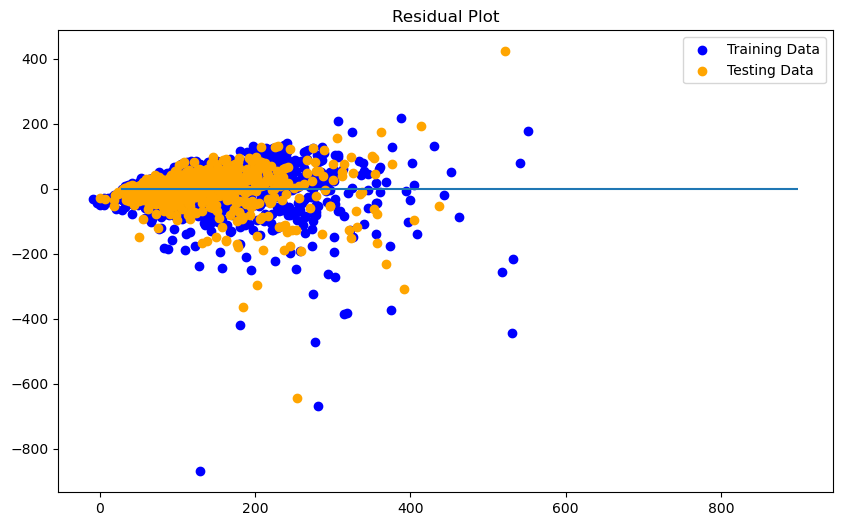

In [27]:
fig = plt.subplots(figsize=(10, 6))
plt.scatter(linear_reg.predict(X_train), linear_reg.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(linear_reg.predict(X_test), linear_reg.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")

### Lasso Regression Model

In [15]:
lasso_reg = Lasso(alpha=0.1)

lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.1)

In [16]:
lasso_reg_pred = lasso_reg.predict(X_test)

print('Mean Absolute Error : {}'.format(mean_absolute_error(y_test, lasso_reg_pred)))
print()
print('Mean Squared Error : {}'.format(mean_squared_error(y_test, lasso_reg_pred)))
print()
print('Root Mean Squared Error : {}'.format(sqrt(mean_squared_error(y_test, lasso_reg_pred))))

Mean Absolute Error : 37.16424792173181

Mean Squared Error : 3700.0675939102616

Root Mean Squared Error : 60.82818091896438


Text(0.5, 1.0, 'Residual Plot')

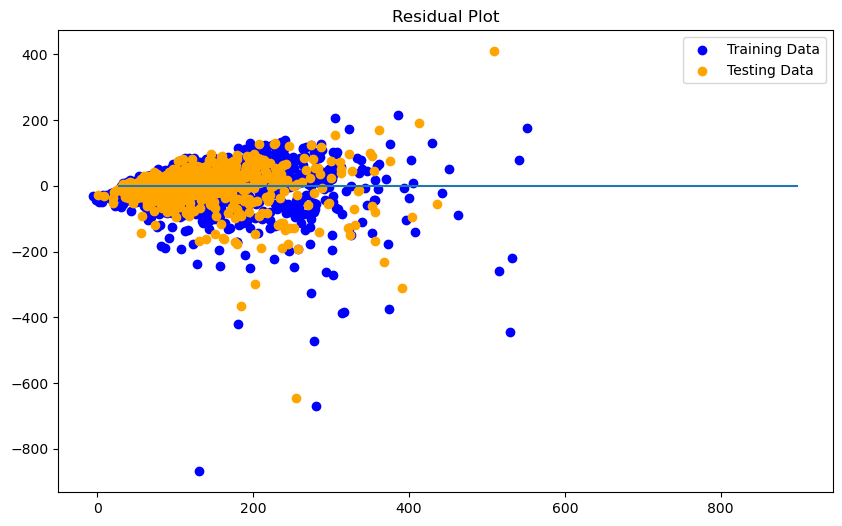

In [28]:
fig = plt.subplots(figsize=(10, 6))
plt.scatter(lasso_reg.predict(X_train), lasso_reg.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(lasso_reg.predict(X_test), lasso_reg.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")

### XGBoost Regression Model

In [17]:
xgb_reg = xgboost.XGBRegressor()

xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [18]:
xgb_reg_pred = xgb_reg.predict(X_test)

print('Mean Absolute Error : {}'.format(mean_absolute_error(y_test, xgb_reg_pred)))
print()
print('Mean Squared Error : {}'.format(mean_squared_error(y_test, xgb_reg_pred)))
print()
print('Root Mean Squared Error : {}'.format(sqrt(mean_squared_error(y_test, xgb_reg_pred))))

Mean Absolute Error : 36.827944955346304

Mean Squared Error : 3966.292591901445

Root Mean Squared Error : 62.978508968547715


Text(0.5, 1.0, 'Residual Plot')

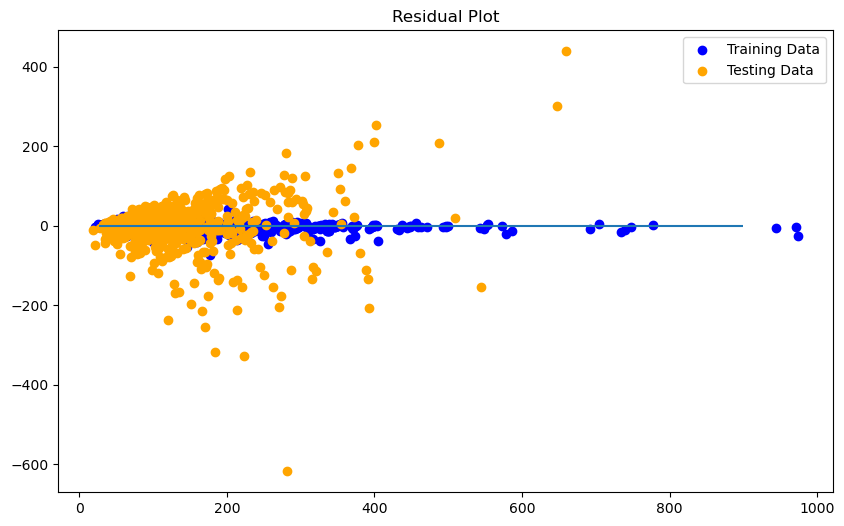

In [29]:
fig = plt.subplots(figsize=(10, 6))
plt.scatter(xgb_reg.predict(X_train), xgb_reg.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(xgb_reg.predict(X_test), xgb_reg.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")

### Random Forest Model

In [30]:
forest_reg = RandomForestRegressor(n_estimators= 500, max_depth=6)

forest_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=500)

In [31]:
forest_reg_pred = forest_reg.predict(X_test)

print('Mean Absolute Error : {}'.format(mean_absolute_error(y_test, forest_reg_pred)))
print()
print('Mean Squared Error : {}'.format(mean_squared_error(y_test, forest_reg_pred)))
print()
print('Root Mean Squared Error : {}'.format(sqrt(mean_squared_error(y_test, forest_reg_pred))))

Mean Absolute Error : 35.99989749978205

Mean Squared Error : 3511.2565048496467

Root Mean Squared Error : 59.25585629159068


Text(0.5, 1.0, 'Residual Plot')

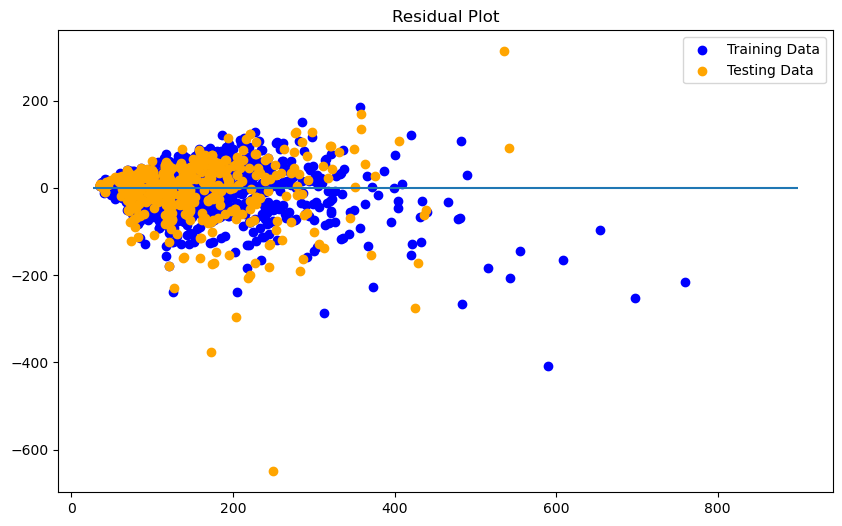

In [32]:
fig = plt.subplots(figsize=(10, 6))
plt.scatter(forest_reg.predict(X_train), forest_reg.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(forest_reg.predict(X_test), forest_reg.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")

Points on or close to the diagonal line indicate that the Random forest and XGBoost model's predictions of the values are quite accurate. The points have been incorrectly predicted if they are distant from the diagonal line.

For the evaluation of the models, we used Mean Absolute Error, also known as L1 loss is one of the most straightforward loss functions and an easy-to-understand evaluation metric. It is calculated by taking the absolute difference between the predicted and actual values and averaging it across the dataset. The Random Forest and XGBoost have the best performance among all the models. The best model is Random Forest with MAE 35.99, meaning the predicted values and actual values difference is approximately 36 points. 